## Homework

### Dataset

In this homework, we will use the California Housing Prices. You can take it from
[Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-09-19 14:43:37--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2022-09-19 14:43:37 (10.3 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [2]:
import pandas as pd
import numpy as np

# EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 

In [3]:
df = pd.read_csv('housing.csv')

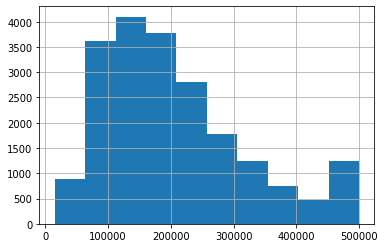

In [4]:
df.median_house_value.hist()

# Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

Select only them.

In [5]:
features = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value']

# Question 1

Find a feature with missing values. How many missing values does it have?

In [6]:
df[features + target].isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

# Question 2

What's the median (50% percentile) for variable 'population'?

In [7]:
df.population.median()

1166.0

# Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe.
* Apply the log transformation to the median_house_value variable using the `np.log1p()` function.


In [8]:
def create_split(df, features, target, val_split=0.2, test_split=0.2, seed=None):

  # shuffle index
  np.random.seed(seed)
  idx = np.array(df.index)
  np.random.shuffle(idx)

  # split index (default 60% train, 20% validation, 20% test)
  train_split = 1 - val_split - test_split
  split_size = (idx.size * np.array([train_split, train_split+val_split])).astype(np.int32)
  idx_split = np.split(idx, split_size)

  # create X
  X_train = df.iloc[idx_split[0]][features].copy().reset_index(drop=True)
  X_val = df.iloc[idx_split[1]][features].copy().reset_index(drop=True)
  X_test = df.iloc[idx_split[2]][features].copy().reset_index(drop=True)

  # create y
  y_train = np.log1p(df.iloc[idx_split[0]][target].values)
  y_val = np.log1p(df.iloc[idx_split[1]][target].values)
  y_test = np.log1p(df.iloc[idx_split[2]][target].values)

  # return
  return (X_train, X_val, X_test, y_train, y_val, y_test)

# Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:
- With 0
- With mean
- With median
- Both are equally good

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [10]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [11]:
# Option 0
df_0 = df.copy().fillna(0)
X_train, X_val, X_test, y_train, y_val, y_test = create_split(df_0, features, target, seed=42)

w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred), 2))


validation 0    0.33
dtype: float64


In [12]:
# Option median
X_train, X_val, X_test, y_train, y_val, y_test = create_split(df, features, target, seed=42)
X_train['total_bedrooms'] = X_train.total_bedrooms.fillna(X_train.total_bedrooms.median())

w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred), 2))

validation 0    0.33
dtype: float64


In [13]:
# Option mean
X_train, X_val, X_test, y_train, y_val, y_test = create_split(df, features, target, seed=42)
X_train['total_bedrooms'] = X_train.total_bedrooms.fillna(X_train.total_bedrooms.mean())

w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_val.dot(w)
print('validation', round(rmse(y_val, y_pred), 2))

validation 0    0.33
dtype: float64


# Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [ ]:
df_0 = df.copy().fillna(0)
X_train, X_val, X_test, y_train, y_val, y_test = create_split(df_0, features, target, seed=42)

In [ ]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('r:', r, '\t', 'rmse:', round(rmse(y_val, y_pred)[0], 2))

r: 0 	 rmse: 0.33
r: 1e-06 	 rmse: 0.33
r: 0.0001 	 rmse: 0.33
r: 0.001 	 rmse: 0.33
r: 0.01 	 rmse: 0.33
r: 0.1 	 rmse: 0.33
r: 1 	 rmse: 0.33
r: 5 	 rmse: 0.34
r: 10 	 rmse: 0.34


# Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [ ]:
df_0 = df.copy().fillna(0)
score = {}

for s in range(10):
  X_train, X_val, X_test, y_train, y_val, y_test = create_split(df_0, features, target, seed=s)
  w_0, w = train_linear_regression(X_train, y_train)
  
  y_pred = w_0 + X_val.dot(w)

  score[s] = rmse(y_val, y_pred)[0]

  print('seed:', s, '\t', 'rmse:', score[s])

print('std:', round(np.std(list(score.values())), 3))

seed: 0 	 rmse: 0.3388430480530326
seed: 1 	 rmse: 0.33623872559566276
seed: 2 	 rmse: 0.3320912318833194
seed: 3 	 rmse: 0.34051536090377893
seed: 4 	 rmse: 0.33890240665742954
seed: 5 	 rmse: 0.34348667257187443
seed: 6 	 rmse: 0.34519809530991635
seed: 7 	 rmse: 0.3395989927407549
seed: 8 	 rmse: 0.34662308731992736
seed: 9 	 rmse: 0.3365926124190451
std: 0.00417077


# Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [ ]:
df_0 = df.copy().fillna(0)
X_train, X_val, X_test, y_train, y_val, y_test = create_split(df_0, features, target, seed=9)

X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = np.concatenate((y_train, y_val))

w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

y_pred = w_0 + X_val.dot(w)
print('test', rmse(y_test, y_pred)[0])

test 0.730124780462471
